# Handling missing data and exploring a variable's distribution in Julia

Here’s a Julia code example focusing on handling missing data, and exploring the shape and spread of our data using the `DataFrames` and `Distributions` packages with the a simulated dataset.  We will also make use of the `Statistics`, `StatsPlots`, and `Random` packages.

## Setup

In [230]:
# Install necessary packages
using Pkg
Pkg.add(["DataFrames", "Statistics", "StatsPlots", "Plots", "Random", "Distributions"])

# Load required packages
using DataFrames, Statistics, StatsPlots, Plots, Distributions


   Resolving package versions...
    Updating `C:\Users\nfoss\.julia\environments\v1.10\Project.toml`
  [31c24e10] + Distributions v0.25.111
  No Changes to `C:\Users\nfoss\.julia\environments\v1.10\Manifest.toml`


## Handling missing data

We will create a dataset that contains missing values so we can work on those problems.  The `Distributions` package allows us to simulate data using specific distributions.  Here, we will utilize the Gaussian distribution in a conventional way, and again sample the Gaussian distribution twice to create a bimodal distribution.  Observe.

In [244]:
# Set a seed for reproducibility
Random.seed!(123)

# Helper function to add missing values with a given probability
function add_missing(data, missing_prob=0.05)
    return [rand() < missing_prob ? missing : x for x in data]
end

# Generate data for 10,000 rows
ID = 1:10000  # Numeric data (IDs)

# Categorical data
Category = [rand(["A", "B", "C"]) for _ in 1:10000]

# Generate normally distributed Score and apply missing values
Score = add_missing(rand(Normal(75, 25), 10000))

# Generate bimodal Age distribution and apply missing values
Age = vcat(rand(Normal(25, 5), 5000), rand(Normal(45, 5), 5000))
Age = add_missing(Age)

# Generate Status with some missing values
Status = add_missing([rand(["Active", "Inactive"]) for _ in 1:10000])

# Create the DataFrame
test_df = DataFrame(ID=ID, Category=Category, Score=Score, Age=Age, Status=Status)

# Display the first few rows of the test DataFrame
describe(test_df, :all)


5×16 DataFrame
 Row │ variable  mean     std      min       q25      median   q75      max    ⋯
     │ Symbol    Union…   Union…   Any       Union…   Union…   Union…   Any    ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ ID        5000.5   2886.9   1         2500.75  5000.5   7500.25  10000  ⋯
   2 │ Category                    A                                    C
   3 │ Score     74.5147  25.124   -16.8624  57.5315  74.4757  91.3581  178.62
   4 │ Age       35.0448  11.1947  7.97581   24.9507  35.0363  45.0404  62.186
   5 │ Status                      Active                               Inacti ⋯
                                                               9 columns omitted

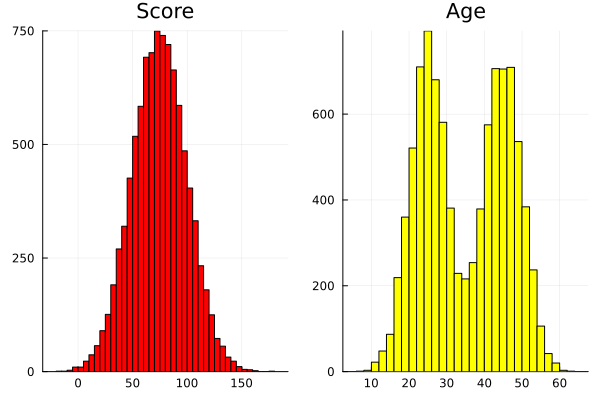

In [245]:
# visualize the distribution of the numeric variables to examine their distribution without imputing the missing values

h1 = histogram(test_df.Score, legend = false, color = :red, title = "Score")
h2 = histogram(test_df.Age, legend =  false, color = :yellow, title = "Age")

histogram_vec = [h1, h2]

plot(histogram_vec...)

## Impute missing values using `DataFrames`

In [248]:
# create a function to easily impute the mean

function mean_imputation(df::DataFrame, col_name::Symbol)
    col = df[!, col_name]
    col_mean = mean(skipmissing(col))
    df[!, col_name] .= coalesce.(col, col_mean)
end

# create a function to easily impute the median

function median_imputation(df::DataFrame, col_name::Symbol)
    col = df[!, col_name]
    col_median = median(skipmissing(col))
    df[!, col_name] .= coalesce.(col, col_median)
end



median_imputation (generic function with 3 methods)

## Try mean imputation and check the distribution

In [252]:
# mean imputation

test_impute_mean = copy(test_df) # create a new dataset so that we do not sacrifice our original data

# imputation

test_impute_mean.Score = mean_imputation(test_impute_mean, :Score)

test_impute_mean.Age = mean_imputation(test_impute_mean, :Age)

describe(test_impute_mean, :all) # no missing values in our Real element columns


5×16 DataFrame
 Row │ variable  mean     std      min       q25      median   q75      max    ⋯
     │ Symbol    Union…   Union…   Any       Union…   Union…   Union…   Any    ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ ID        5000.5   2886.9   1         2500.75  5000.5   7500.25  10000  ⋯
   2 │ Category                    A                                    C
   3 │ Score     74.5147  24.4723  -16.8624  58.6255  74.5147  90.3641  178.62
   4 │ Age       35.0448  10.9163  7.97581   25.2734  35.0448  44.6874  62.186
   5 │ Status                      Active                               Inacti ⋯
                                                               9 columns omitted

## More histograms to visualize the distributions

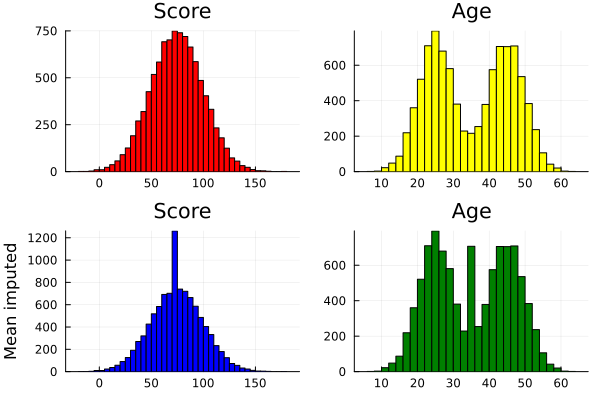

In [253]:
# visualize the distribution of score and age after mean imputation

h_impute_1 = histogram(test_impute_mean.Score, legend = false, color = :blue, title = "Score", ylab = "Mean imputed")
h_impute_2 = histogram(test_impute_mean.Age, legend =  false, color = :green, title = "Age")

histogram_vec = [h1, h2, h_impute_1, h_impute_2]

plot(histogram_vec..., layout = (2,2)) # An interesting spike in the distribution with a spike at the mean

## Try median imputation

The results from mean imputation were unremarkable and did not seem to make a change in the distribution of the variables.

Now to test median imputation.

In [254]:
# imputing the median

test_impute_median = copy(test_df)

test_impute_median.Score = median_imputation(test_impute_median, :Score)

test_impute_median.Age = median_imputation(test_impute_median, :Age)

# check the distribution

describe(test_impute_median) # the distribution has changed slightly using median imputation

# visualize the distribution again, this time via horizontal boxplots

5×7 DataFrame
 Row │ variable  mean     min       median   max       nmissing  eltype        ⋯
     │ Symbol    Union…   Any       Union…   Any       Int64     Type          ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ ID        5000.5   1         5000.5   10000            0  Int64         ⋯
   2 │ Category           A                  C                0  String
   3 │ Score     74.5127  -16.8624  74.4757  178.623          0  Float64
   4 │ Age       35.0444  7.97581   35.0363  62.1862          0  Float64
   5 │ Status             Active             Inactive       506  Union{Missing ⋯
                                                                1 column omitted

## Try boxplots to visualize the distribution of the median imputed variables

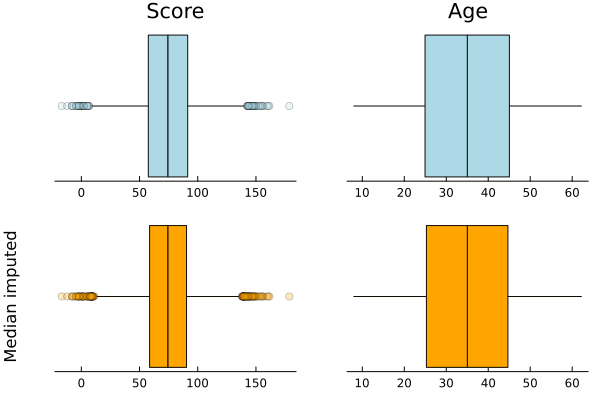

In [263]:
# use the @df macro to chain a bit
# boxplots, made horizontal for ease of use

box_1 = @df test_df boxplot(skipmissing(:Score), 
horizontal = true, legend = false, 
title = "Score", 
color = :lightblue, 
orientation = :horizontal, 
grid = false, 
whisker_width = 0, 
yaxis = false,
markeralpha = 0.25
)

box_2 = @df test_df boxplot(skipmissing(:Age), 
horizontal = true, 
legend = false, 
title = "Age", 
color = :lightblue, 
orientation = :horizontal, 
grid = false, 
whisker_width = 0, 
yaxis = false
)

box_3 = @df test_impute_median boxplot(skipmissing(:Score), 
horizontal = true, legend = false, 
ylab = "Median imputed", 
color = :orange, 
orientation = :horizontal, 
grid = false, 
whisker_width = 0, 
yaxis = false,
markeralpha = 0.25
)

box_4 = @df test_impute_median boxplot(skipmissing(:Age), 
horizontal = true, 
legend = false, 
color =  :orange, 
orientation = :horizontal, 
grid = false, 
whisker_width = 0, 
yaxis = false,
markeralpha = 0.25
)

# vector of boxplots for a patchwork of plots
boxplot_vec = [box_1 box_2 box_3 box_4]

# patchwork
plot(boxplot_vec..., layout = (2,2))

## Distributions seemed to respond better to the median

A conservative choice is typically the median unless the mean does not seem to significantly shift the distribution of a variable.

If there are significant outliers in the data, the median is typically more robust to those and may be a better option for imputation methods.

That said, there are other imputation methods that can be leveraged by `Impute.jl`, but that is outside the scope of this notebook.

Let's continue on with a look at correlation.

In [256]:
# fill in the missing categorical values, and complete a bar plot

test_impute_median.Status .= coalesce.(test_impute_median.Status, "Unknown")

# check variable
describe(test_impute_median)

5×7 DataFrame
 Row │ variable  mean     min       median   max      nmissing  eltype   
     │ Symbol    Union…   Any       Union…   Any      Int64     DataType 
─────┼───────────────────────────────────────────────────────────────────
   1 │ ID        5000.5   1         5000.5   10000           0  Int64
   2 │ Category           A                  C               0  String
   3 │ Score     74.5127  -16.8624  74.4757  178.623         0  Float64
   4 │ Age       35.0444  7.97581   35.0363  62.1862         0  Float64
   5 │ Status             Active             Unknown         0  String

In [257]:
# create a matrix out of our median imputed dataset

test_matrix = Matrix(test_impute_median[:, [:Score, :Age]])

# get correlation
println("Pearson correlation of Age and Score")
cor_test_matrix = cor(test_matrix)

Pearson correlation of Age and Score


2×2 Matrix{Float64}:
  1.0         -0.00784408
 -0.00784408   1.0

## Median's affect on data visualization and predictive analytics

Notice in the plot below how imputed values are clearly seen at the median.  This is still problematic and does not give us what we need for machine learning tasks to make good predictions.

Smarter methods such as k-nearest neighbors (KNN) and classification and regression trees (CART) methods can impute data that can follow natural patterns in the data.

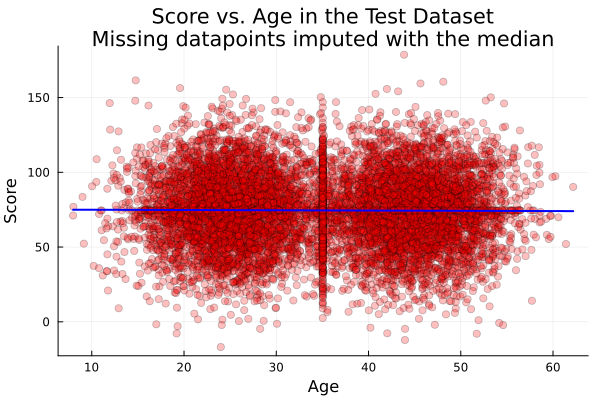

In [259]:
# check the correlation using a regression model

@df test_impute_median scatter(:Age, :Score, 
legend = false, 
smooth = true, 
color = :red, 
markeralpha = 0.25, 
linecolor = :blue, 
linewidth = 2,
title = "Score vs. Age in the Test Dataset\nMissing datapoints imputed with the median",
xlab = "Age",
ylab = "Score"
)

## Bar plot of the average score by status

Now that status has imputed values, we can successfully take the average across groups and do not need to deal with missing values.

First, we need to make a summary table of the average scores for each status.

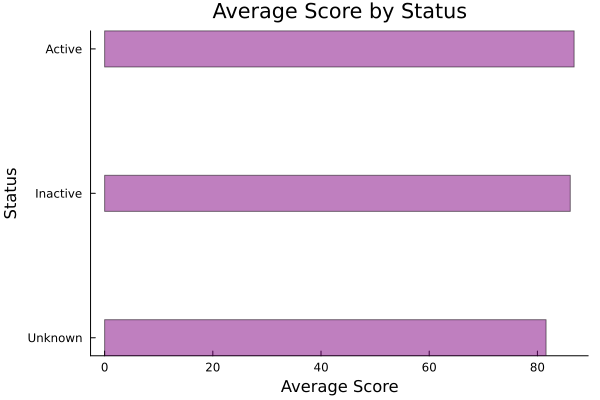

In [223]:
# Calculate the average score for each status
average_scores = combine(groupby(test_impute_median, :Status), :Score => mean => :AverageScore)

# Sort by average score in descending order
sorted_scores = sort(average_scores, :AverageScore, rev=false)

# Create a horizontal bar plot
bar(
    sorted_scores.Status, 
    sorted_scores.AverageScore, 
    title="Average Score by Status", 
    xlabel="Status", 
    ylabel="Average Score",
    legend = false,  # Disable the legend if not needed
    bar_width = 0.25,  # Control the spacing between bars
    grid = false,
    alpha = 0.5,
    permute = (:x, :y),
    color = :purple
)

## One last exploration

Let's check out the grouped means of category and status.

In this way, we may find hidden patterns in the data even though we already know the types of distributions we are working with.

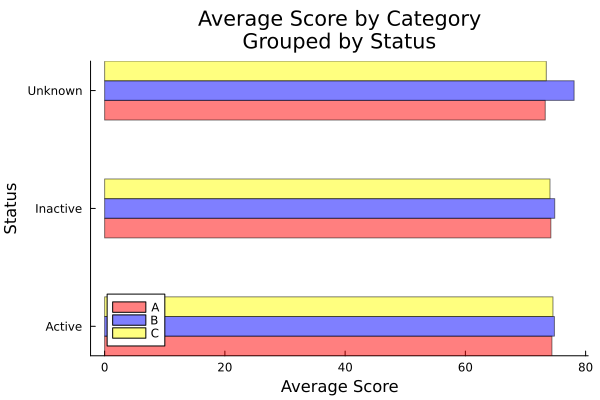

In [280]:
# Calculate the average score for each category and status
average_scores = combine(groupby(test_impute_median, [:Category, :Status]), :Score => mean => :AverageScore)

# Sort by average score in descending order
sorted_scores = sort(average_scores, :AverageScore, rev=false)

# Create a horizontal bar plot
groupedbar(
    sorted_scores.Status, 
    sorted_scores.AverageScore,
    group = sorted_scores.Category, 
    title="Average Score by Category\nGrouped by Status\n", 
    xlabel="Status", 
    ylabel="Average Score",
    legend = :bottomleft,  # Disable the legend if not needed
    bar_width = 0.5,  # Control the spacing between bars
    grid = false,
    alpha = 0.5,
    color = [:red :blue :yellow],
    permute = (:x, :y)
)

## Conclusion

Julia has robust methods to impute data, and the `Impute.jl` package can do even more to help.

I will try to learn and cover what other imputation functions such as KNN can do via julia in the future.

I hope this notebook was helpful!  Until next time.